### Collisional-radiative model for Argon Plasma
#### Rates fitting
See: https://doi.org/10.1063/1.3585688

In [1]:
import os
import copy
import numpy as np
import scipy as sp
import dill as pickle
import matplotlib.pyplot as plt

In [2]:
# Constants
from scipy.constants import physical_constants as pc

UEPS0 = pc["vacuum electric permittivity"][0]
UNA   = pc["Avogadro constant"][0]
UKB   = pc["Boltzmann constant"][0]
UME   = pc["electron mass"][0]
UE    = pc["elementary charge"][0]

Inputs

In [3]:
path_to_kin = "./../rates/kin_raw.p"
path_to_rad = "./../rates/rad_raw.p"
fit_coll_int = False

In [4]:
fit_rates_rad = ("BF", "BFp")
fit_rates_exc = ("EXe", "EXh", "Ie", "Ih")

In [5]:
# Save path
out_path = "./../rates/"
os.makedirs(out_path, exist_ok=True)

Fit functions and parameters
> Arrhenius law

In [6]:
ARR_PARAM = ("A", "beta", "Ta")

# Arrhenius law - Linear
def arrhenius(T, *c):
  A, beta, Ta = c
  return A * np.exp(beta*np.log(T) - Ta/T)

# Arrhenius law - Log
def arrhenius_ln(T, *c):
  logA, beta, Ta = c
  return logA + beta*np.log(T) - Ta/T

# Arrhenius law Jacobian - Log
def arrhenius_ln_jac(T, *c):
  return np.vstack([np.ones_like(T), np.log(T), -1/T]).T

# Curve fit arguments
cfit_args = {
  "f": arrhenius_ln,
  "p0": [-20, 0, 1e3],
  "method": "trf",
  "jac": arrhenius_ln_jac,
  "bounds": (
    [-np.inf, -np.inf,   0], # Lower bounds
    [     -5,  np.inf, 1e6]  # Upper bounds
  )
}

# Fitting functions
def fit_rate(T, k):
  indices = k > 0
  T = T[indices]
  k = np.log(k[indices])
  if (len(T) < 4):
    param = np.zeros((3,))
  else:
    param = sp.optimize.curve_fit(
      xdata=T,
      ydata=k,
      **cfit_args
    )[0]
    param[0] = np.exp(param[0])
  return param

def fit_rates(T, rates):
  shape = rates.shape[:-1]
  rates = rates.reshape(-1, len(T))
  param = np.stack([fit_rate(T, k) for k in rates], 1)
  param = {p: param[i].reshape(shape) for (i, p) in enumerate(ARR_PARAM)}
  return param

> Electron-neutral collision rate

In [7]:
def compute_ve(T):
  # Electron mean thermal velocity
  return np.sqrt((8.0*UKB*T)/(np.pi*UME))

def coll_int_to_rate_ln(T, Q, f=1.0):
  # Convert from Q (collision integral) to k (collision rate)
  return np.log(f * compute_ve(T) * Q)

def coll_rate_en_ln(T, c):
  # > See: https://doi.org/10.1007/978-1-4419-8172-1 - Eq. 11.3
  # Common factors
  lnT = np.log(T)
  fac = np.exp((lnT - c[0])/c[1])
  # Collision integral [m^2]
  Qen = c[2]*lnT**c[5]*fac/(fac + 1.0/fac) \
      + c[6]*np.exp(-((lnT - c[7])/c[8])**2) \
      + c[3] + c[9]*lnT**c[4]
  Qen *= 1e-20 * np.pi
  # Collision rate
  return coll_int_to_rate_ln(T, Qen, f=8.0/3.0)

def coll_rate_en_ln_data(dtb):
  return np.log(2.0*dtb["EN"]["values"])

**Kinetics**

In [8]:
kin_raw = pickle.load(open(path_to_kin, "rb"))
T = kin_raw["T"]

In [9]:
kin_fit = copy.deepcopy(kin_raw)
for name in fit_rates_exc:
  kin_fit[name]["values"] = fit_rates(T, kin_raw[name]["values"])

Electron-neutrals collision rate

In [10]:
if fit_coll_int:
  param = sp.optimize.leastsq(
    func=lambda c: coll_rate_en_ln_data(kin_raw) - coll_rate_en_ln(T, c),
    x0=kin_raw["EN"]["Q11_fit"],
    maxfev=int(1e5)
  )
  kin_fit["EN"]["Q11_fit"] = param[0]

**Radiation**

In [11]:
rad_raw = pickle.load(open(path_to_rad, "rb"))
T = rad_raw["T"]

In [12]:
rad_fit = copy.deepcopy(rad_raw)
for name in fit_rates_rad:
  rad_fit[name]["values"] = fit_rates(T, rad_raw[name]["values"])

Compare fit rates

In [13]:
def pick_rate():
  name = np.random.choice(fit_rates_rad+fit_rates_exc)
  dtb = rad_fit if (name in fit_rates_rad) else kin_fit
  size = dtb[name]["values"]["A"].size
  rate = 0.0
  while (rate == 0.0):
    i = np.random.choice(size)
    rate = dtb[name]["values"]["A"].reshape(-1)[i]
  return name, i

def compute_rates(name, i):
  dtb_fit = rad_fit if (name in fit_rates_rad) else kin_fit
  dtb_raw = rad_raw if (name in fit_rates_rad) else kin_raw
  param = [dtb_fit[name]["values"][p].reshape(-1)[i] for p in ARR_PARAM]
  k_fit = arrhenius(T, *param)
  k_raw = dtb_raw[name]["values"].reshape(-1, len(T))[i]
  return k_fit, k_raw

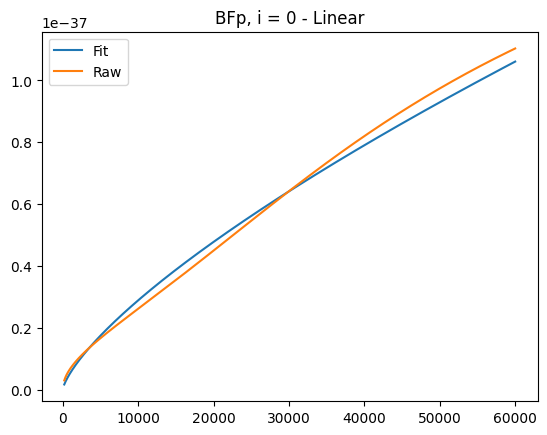

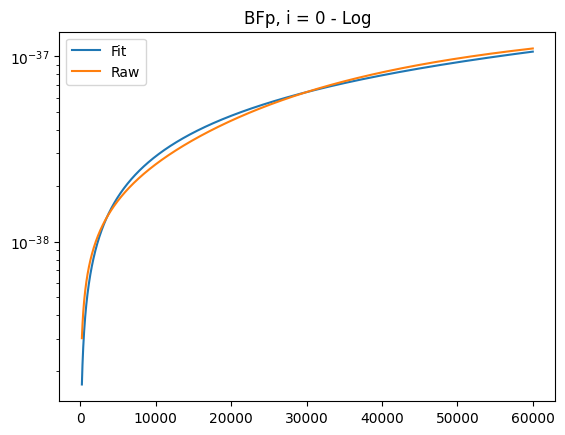

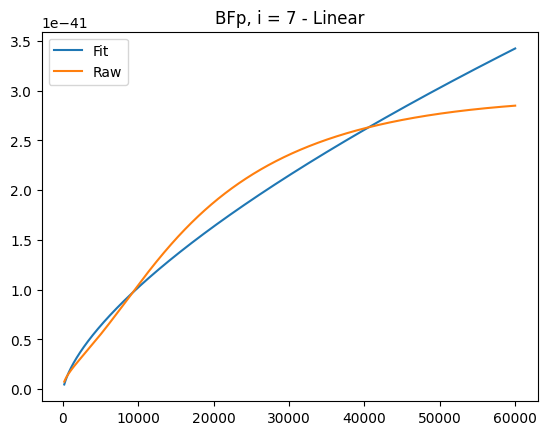

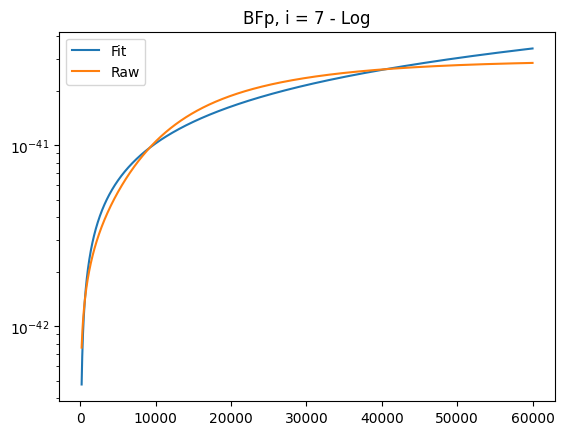

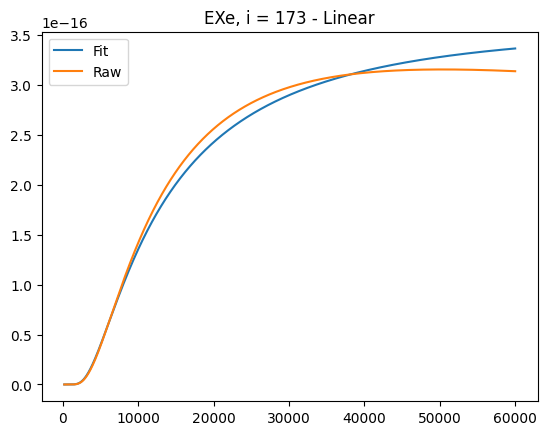

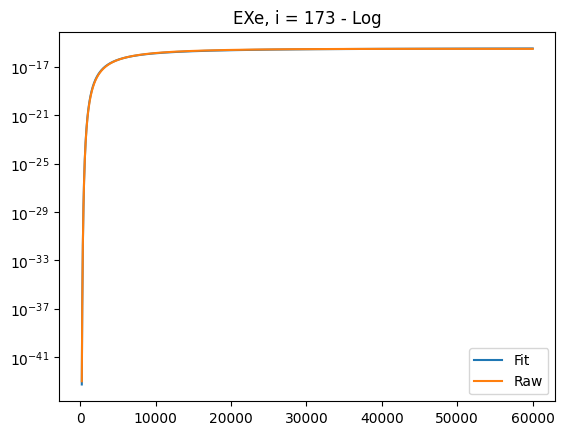

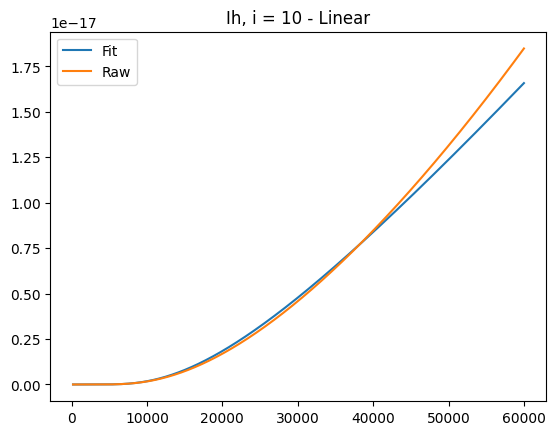

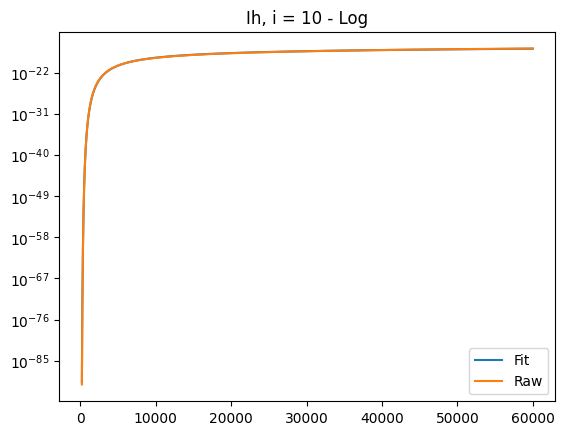

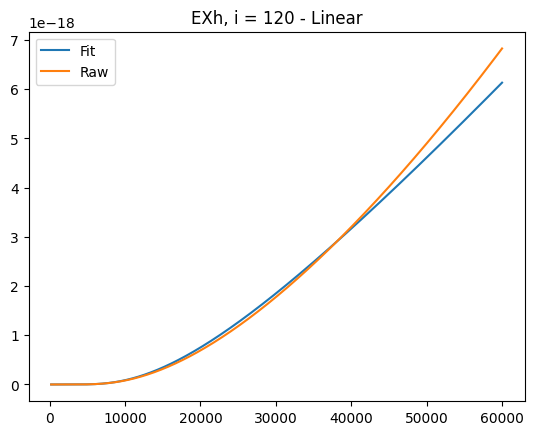

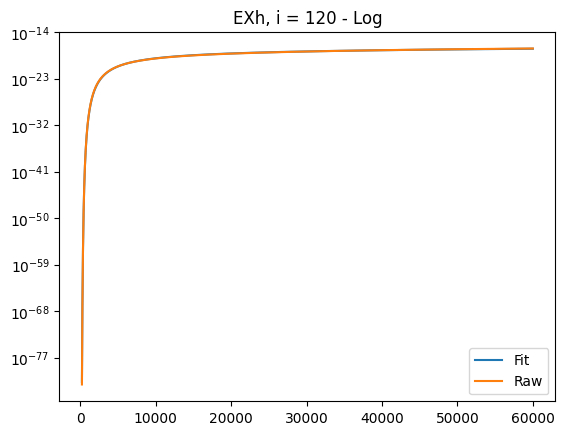

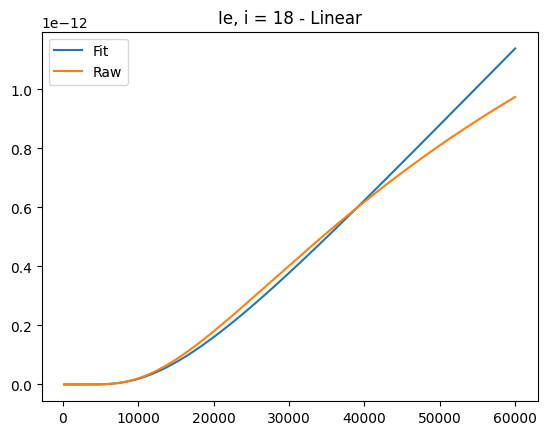

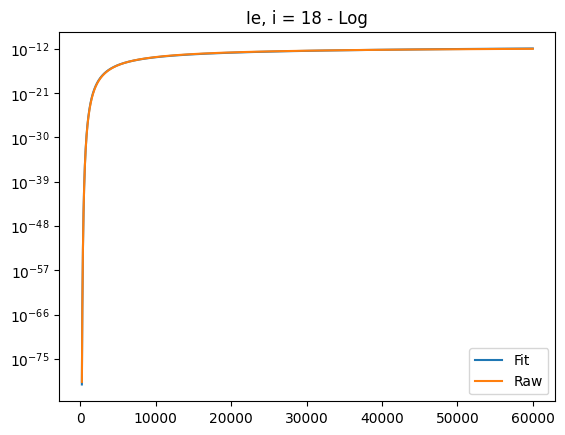

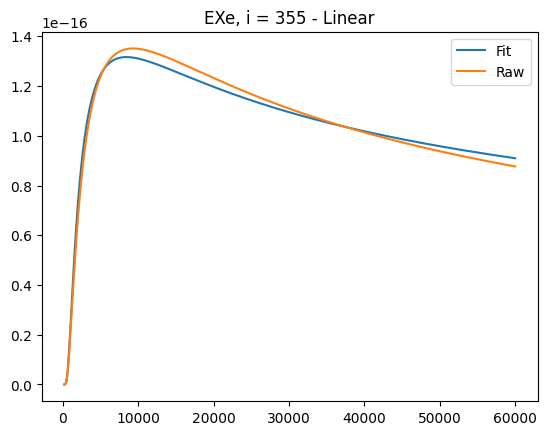

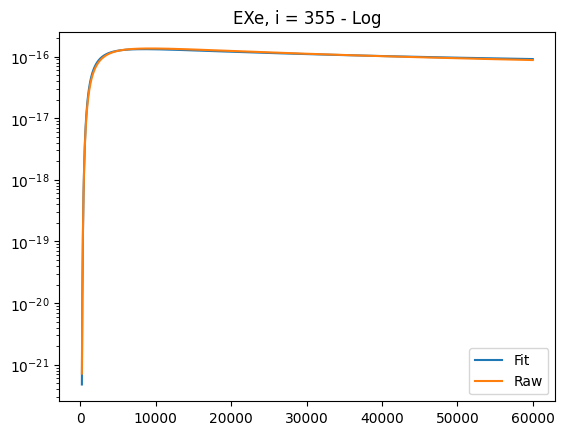

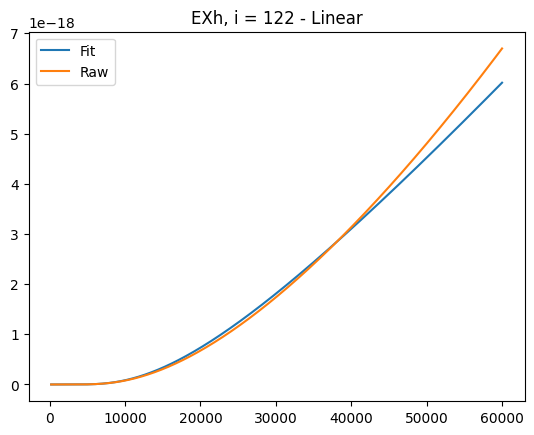

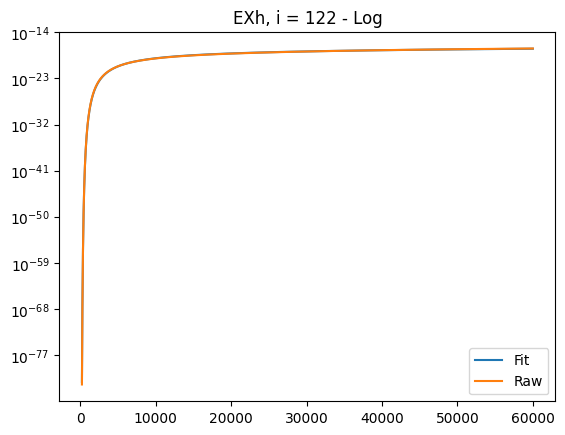

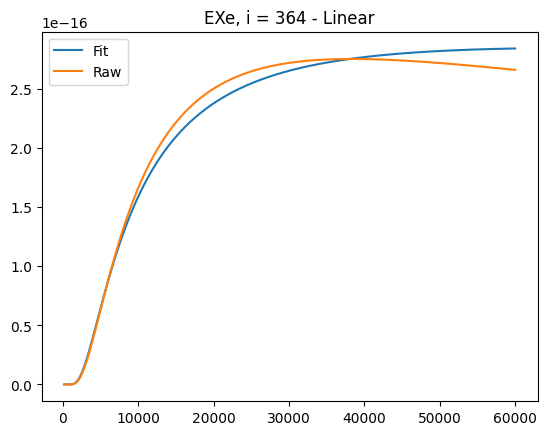

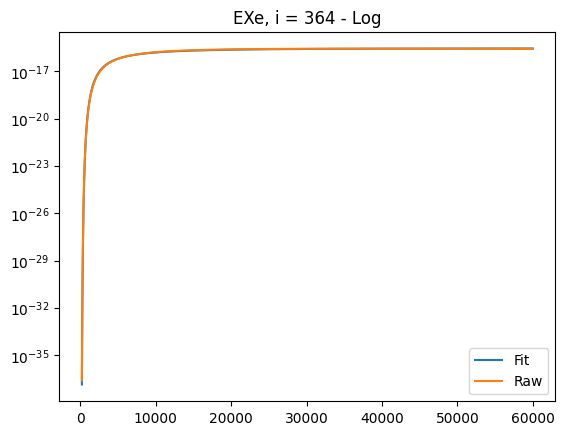

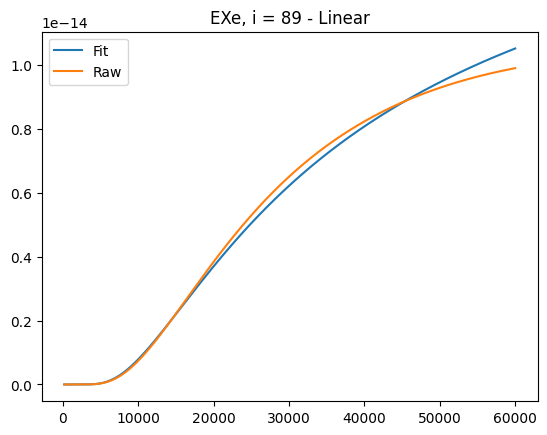

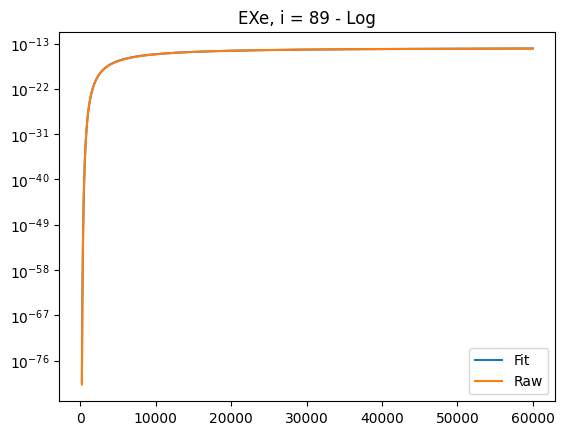

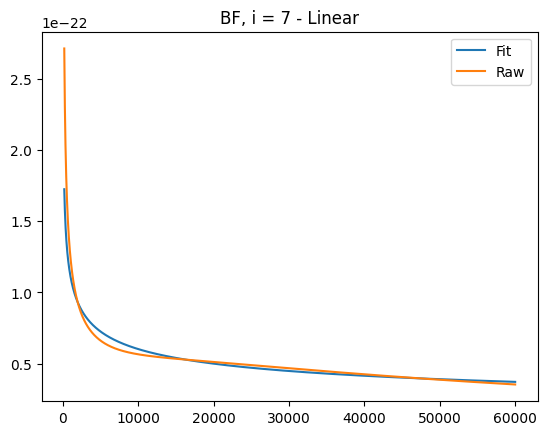

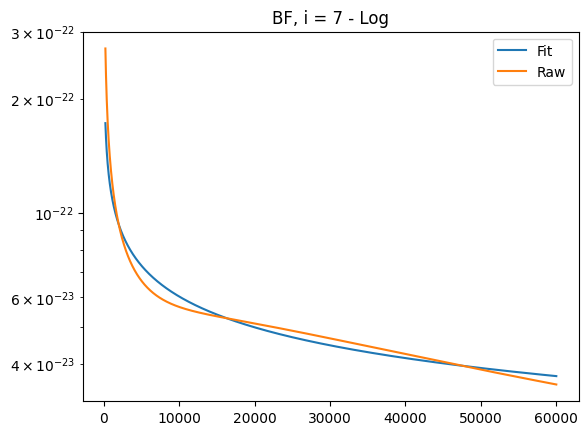

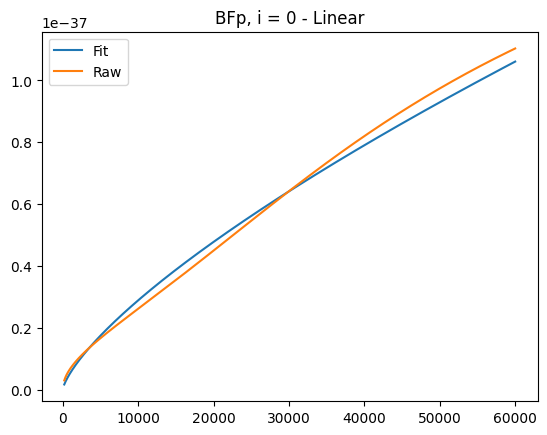

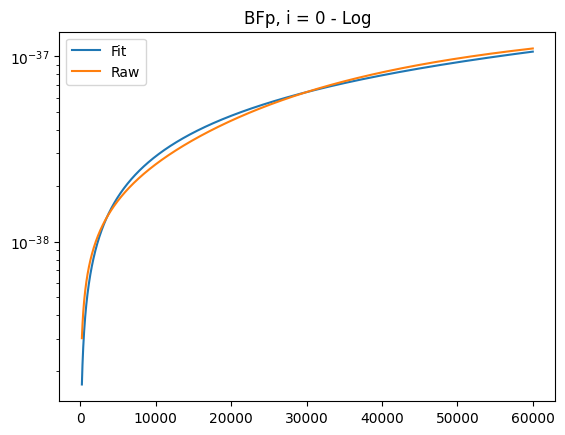

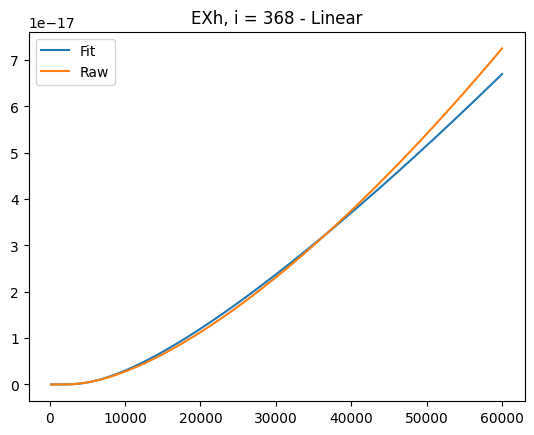

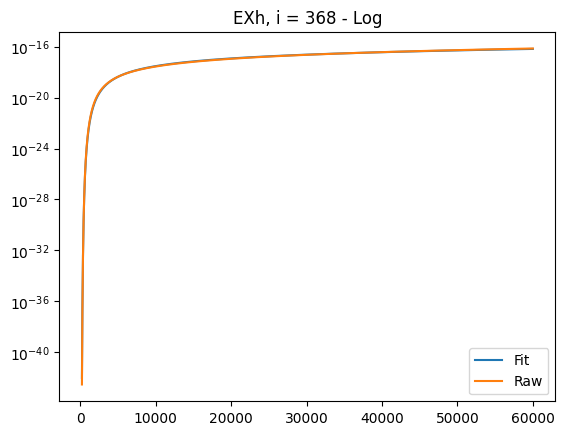

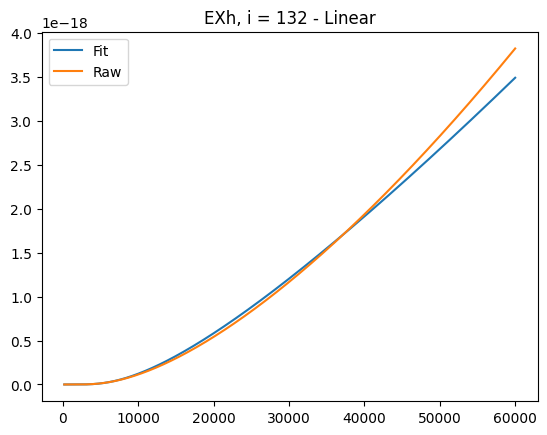

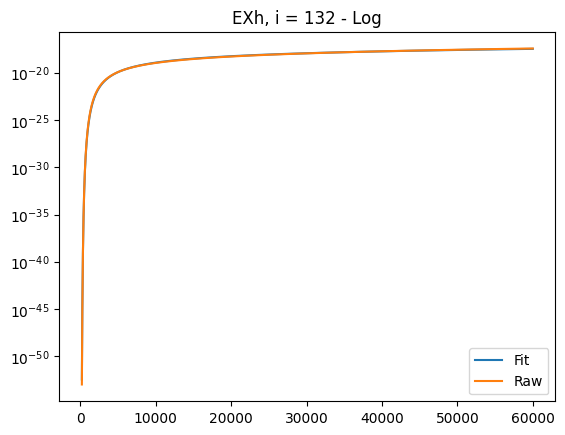

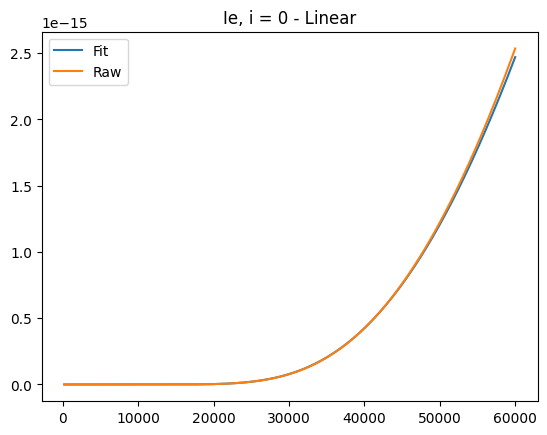

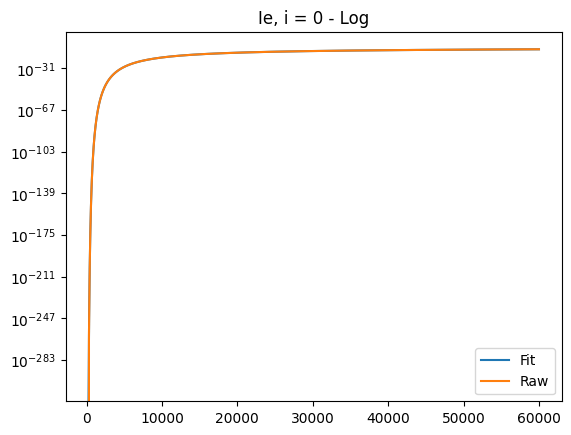

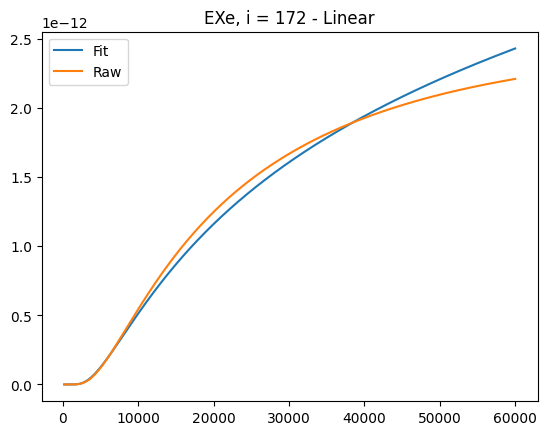

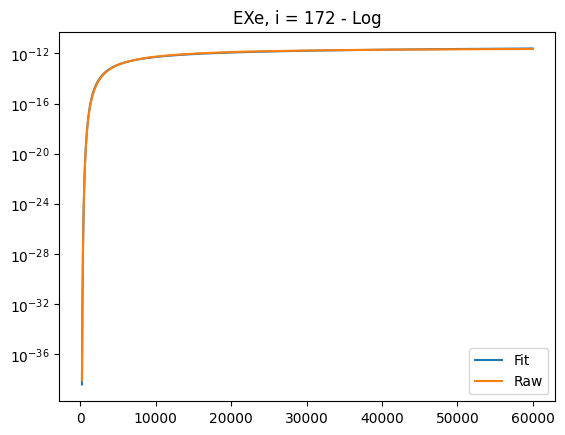

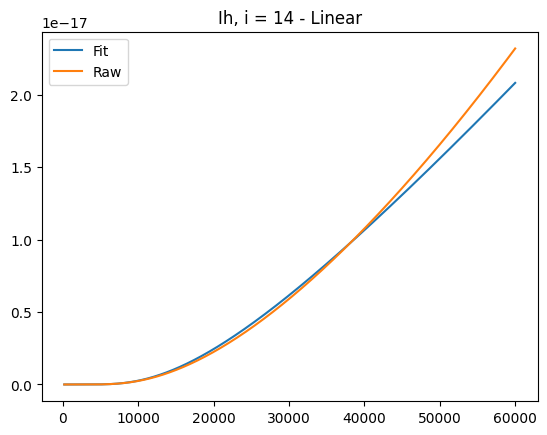

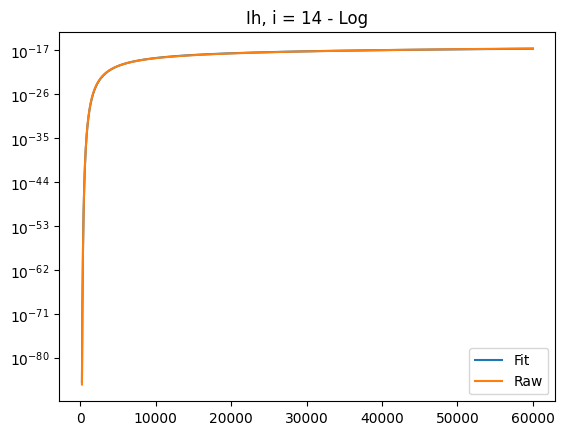

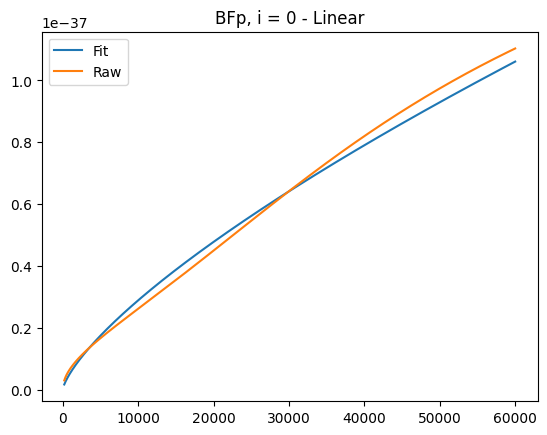

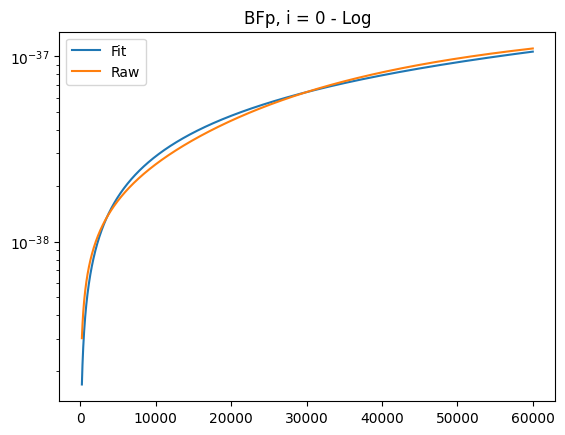

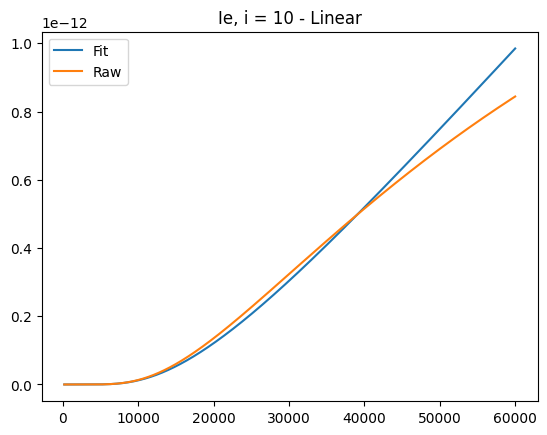

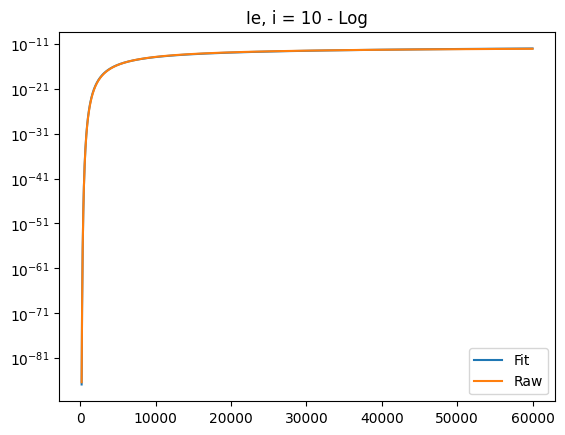

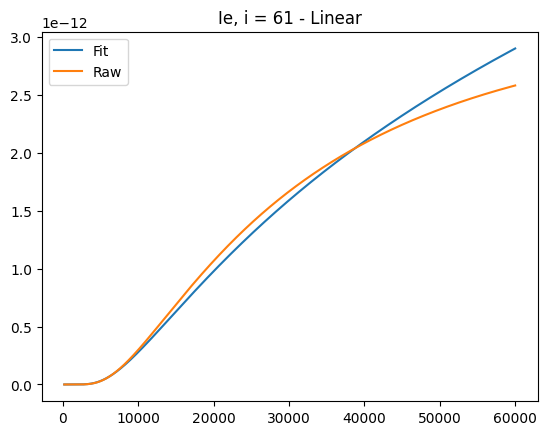

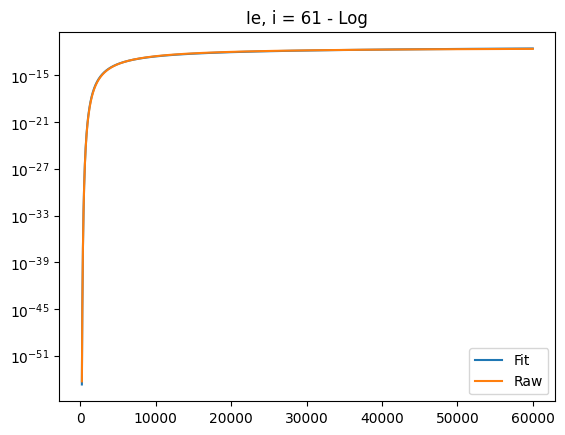

In [14]:
for i in range(20):
  name, i = pick_rate()
  k_fit, k_raw = compute_rates(name, i)
  plt.plot(T, k_fit, label="Fit")
  plt.plot(T, k_raw, label="Raw")
  plt.title(f"{name}, i = {i} - Linear")
  plt.legend()
  plt.show()
  plt.close()
  plt.semilogy(T, k_fit, label="Fit")
  plt.semilogy(T, k_raw, label="Raw")
  plt.title(f"{name}, i = {i} - Log")
  plt.legend()
  plt.show()
  plt.close()

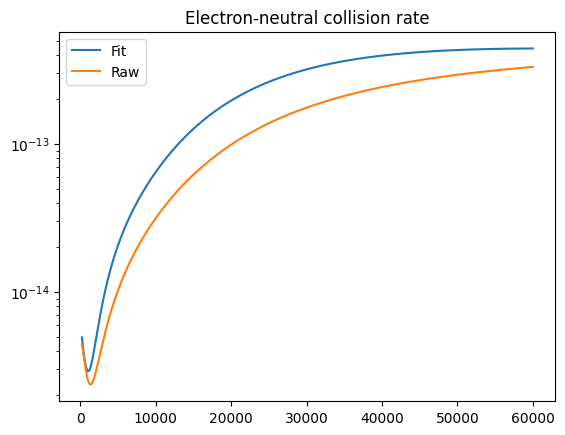

In [15]:
c = kin_fit["EN"]["Q11_fit"]
k_fit = np.exp(coll_rate_en_ln(T, c))
k_raw = np.exp(coll_rate_en_ln_data(kin_raw))
plt.semilogy(T, k_fit, label="Fit")
plt.semilogy(T, k_raw, label="Raw")
plt.title(f"Electron-neutral collision rate")
plt.legend()
plt.show()
plt.close()

Save fit rates

In [16]:
pickle.dump(kin_fit, open(out_path + "/kin_fit.p", "wb"))
pickle.dump(rad_fit, open(out_path + "/rad_fit.p", "wb"))